<hr style="height:2pt">

**Install below package using terminal**

"conda install -c glemaitre imbalanced-learn"

In [1]:
!pip install --upgrade pip
!pip install -U sklearn
!pip install imblearn
!pip install textblob
!pip install -U imbalanced-learn
!pip install xgboost
!pip install -U seaborn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [2]:
import sys
print(sys.executable)

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import display

import random

c:\Users\ianka\AppData\Local\Programs\Python\Python311\python.exe


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import FunctionTransformer 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

from sklearn.svm import SVC 
from xgboost.sklearn import XGBClassifier 
import itertools
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from textblob import Word
from sklearn.ensemble import VotingClassifier 

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

# Prediction of Charge-Offs

We will consider the loan status as the response variable, a binary outcome for a loan with value 0 for fully paid and 1 for Charged Off.

We will work with data previously cleaned and augmented with census information. We will use a subset of loans which were fully paid or charged-off.

In [4]:
np.random.seed(9999)

In [5]:
# Entire data - please use this data set when you run it on AWS or a powerful machine.
#df_loan_accepted_census_cleaned = pd.read_csv('http://digintu.tech/tmp/cs109a/df_loan_accepted_census_cleaned_closed_2007-2015.csv')

# 1% of the data
# 1% of all closed loans between 2007 and 2015, cleaned and augmented with census data - 73 MB
#df_loan_accepted_census_cleaned = pd.read_csv('http://digintu.tech/tmp/cs109a/df_loan_accepted_census_cleaned_closed_2007-2015_10.csv').sample(frac=.1) 

# 10% of the data
# 10% of all closed loans between 2007 and 2015, cleaned and augmented with census data - 73 MB
df_loan_accepted_census_cleaned = pd.read_csv('https://s3.amazonaws.com/ruxton.ai/df_loan_accepted_census_cleaned.csv')

In [6]:
df_loan = df_loan_accepted_census_cleaned.copy()
df_loan = df_loan[df_loan.loan_status.isin(['Charged Off', 'Fully Paid'])]

## Features Selection

Our goal is now to do exploratory analysis using predictive models in order to find important features in closed loans.

Statistical tests can be used to select features that have the strongest relationship with the response variable. 

The Recursive Feature Elimination works by recursively removing variables and building a model on those variables that remain. Model accuracy is used to select the variables which contribute the most to the response.

In this section we use a model-based approach of features selection using bagged trees and PCA. 



### Manual features selection

Using domain knowledge, we remove a list of features as manual feature selection. 
The following list of predictors are those which we MUST not use since they are data gathered AFTER the loan is funded. The reason to exclude them is because these features will not be available in unseen future dataset. Those features are highly correlated to charged-off loans and would otherwise bias our results.

In [8]:
not_predictor = [
'chargeoff_within_12_mths',   
'collection_recovery_fee',
'debt_settlement_flag',
'debt_settlement_flag_date',
'deferral_term',
'funded_amnt_inv',
'funded_amnt',
'hardship_amount',
'hardship_dpd',
'hardship_end_date',
'hardship_flag',
'hardship_last_payment_amount',
'hardship_length',
'hardship_loan_status',
'hardship_payoff_balance_amount',
'hardship_reason',
'hardship_start_date',
'hardship_status',
'hardship_type',
'last_credit_pull_d',
'last_fico_range_high',
'last_fico_range_low',
'last_pymnt_amnt',
'last_pymnt_d',
'next_pymnt_d',
'orig_projected_additional_accrued_interest',
'out_prncp',
'out_prncp_inv',
'payment_plan_start_date',
'pymnt_plan',
'recoveries',
'settlement_amount',
'settlement_date',
'settlement_percentage',
'settlement_status',
'settlement_term',
'total_pymnt',
'total_pymnt_inv',
'total_rec_int',
'total_rec_late_fee',
'total_rec_prncp',
'verification_status'
]

**Dropping non-relevant columns**


Features like 'index', 'id', 'url' and so on are dropped as they are not relevant to our goal of loan status prediction.

We drop the index column.

In [9]:
not_predictor  += ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1']

We drop the id, URL

In [10]:
not_predictor  += ['id', 'url']

We drop the employment title, loan title and description, which contains too many distinct values and cannot be easily categorized.

In [11]:
not_predictor += ['emp_title', 'title', 'desc']

We drop the success flag since it contains the same information as the loan status.

In [12]:
not_predictor += ['success']

We remove following the issue date, quarter and year, which is less relevant for future loans, we only keep the issue month (Jan to Dec).

In [13]:
not_predictor += ['issue_q', 'issue_d']

The grade and subgrade are categories which the LendingClub match to interest rates. Although the categories are fixed, the interest rate can slightly change within each category over the time. 

The term is calculated using the amount and the interest rate.

It follows that `int_rate`, `grade`, `sub_grade` are correlated. Furthermore `loan_amnt`, `int_rate` and `term` define the `installment`. These relationships would bring collinearity into our model for features selection.

We will therefore work with `loan_amnt`, `grade`, `sub_grade` and `term`. If it comes out that these features are important for predicting charge-off, we will conclude that their related variables `int_rate`, and `installment` are also important.

In [14]:
not_predictor += ['int_rate', 'installment']

As far as FICO is concerned, there are 6 variables. Four of them are determined at the initial loan application, thus we can use them. It doesn't seem that they are updated. 

These 2 are significant and collinear, so only one needs to be selected. We choose

    - fico_range_high
    - fico_range_low

These 2 are not so significant and, we believe are used for joint applications.

    - sec_app_fico_range_high
    - sec_app_fico_range_low


However, These two are created, and undoubtedly updated, throughout the loan life. They should not be used:

    - last_fico_range_high
    - last_fico_range_low

In [15]:
not_predictor += ['sec_app_fico_range_high', 'sec_app_fico_range_low', 'last_fico_range_high', 'last_fico_range_low']

As our EDA has shown, information related to gender, race, zip code and state can lead to some unfair handling by a predictive model. We will assume here that removing them as predictor would solve this issue. We further assume that the remaining predictors will not be correlated in any way with census information.

In [16]:
not_predictor += ['addr_state','zip_code','Population', 'median_income_2016', 
               'female_pct', 'male_pct', 
               'Black_pct', 'White_pct', 'Native_pct', 'Asian_pct', 'Hispanic_pct', 
               'household_family_pct', 'poverty_level_below_pct', 'Graduate_Degree_pct', 'employment_2016_rate']

#### **Correlation and redundancy**

Features-pairs which correlate by either -1 or +1 can be considered to be redundant. However High absolute correlation does not imply redundancy of features in the context of classification, see textbook [4] . Therefore we will have a closer look at each correlation.

In [18]:
# source code adapted from [5]
def find_high_correlated_features(frame):
    numeric_frame = frame.select_dtypes(include=['number'])
    new_corr = numeric_frame.corr()
    new_corr.loc[:, :] = np.tril(new_corr, k=-1)
    new_corr = new_corr.stack()
    print(new_corr[(new_corr > 0.80) | (new_corr < -0.80)])

predictor = list(set(df_loan_accepted_census_cleaned.columns) - set(not_predictor))
find_high_correlated_features(df_loan_accepted_census_cleaned[predictor])


total_bc_limit              total_rev_hi_lim        0.820915
mths_since_last_record      pub_rec_bankruptcies    0.814032
num_op_rev_tl               num_rev_tl_bal_gt_0     0.817170
                            open_acc                0.808957
bc_open_to_buy              total_bc_limit          0.855208
num_sats                    open_acc                0.959349
                            num_op_rev_tl           0.842700
num_rev_accts               num_bc_tl               0.853090
                            num_op_rev_tl           0.812411
fico_range_high             fico_range_low          1.000000
tot_hi_cred_lim             tot_cur_bal             0.982460
num_actv_rev_tl             num_rev_tl_bal_gt_0     0.984812
                            num_op_rev_tl           0.813259
total_il_high_credit_limit  total_bal_ex_mort       0.887616
dtype: float64


In [19]:
not_predictor += ['fico_range_low','num_rev_tl_bal_gt_0', 'num_actv_rev_tl','open_il_12m','open_rv_12m','avg_cur_bal','tot_hi_cred_lim','num_bc_tl']

`fico_range_low` and `fico_range_low` are highly correlated. We keep the high value.

The Number of revolving trades with balance >0 `num_rev_tl_bal_gt_0` and the Number of currently active revolving trades `num_actv_rev_tl` are highly correlated with the Number of currently active bankcard accounts `num_actv_bc_tl`. It is safe to remove the formers for our classification task for identifying fully paid loans from charged-off ones.

The number of open credit lines `open_acc` (preapproved loans between a financial institution and borrower that may be used repeatedly up to a certain limit and can subsequently be paid back prior to payments coming due) in the borrower's credit file is highly correlated with the Number of satisfactory accounts (good standing accounts that have been paid in full and on time) `num_sats`. We will keep both features.

`open_il_24m` and `open_il_12m` are the Number of installment accounts opened in past 24 and 12 months respectively. Both values are strongly correlated. We will consider 24 months period since it includes 12 months period. We will handle `open_rv_12m` and `open_rv_24m` in the same way (Number of revolving trades opened in past 12, resp. 24 months).

`tot_cur_bal`, `avg_cur_bal` Total and average current balance of all accounts are strongly related to `tot_hi_cred_lim`, Total high credit/credit limit. We will only keep the total current balance.

`num_rev_accts` Number of revolving accounts (account created by a lender to represent debts where the outstanding balance does not have to be paid in full every month by the borrower to the lender) and `num_bc_tl` Number of bankcard accounts are correlated. This is because credit cards are usually considered as revolving accounts. We assume that the number of revolving accounts better describe the risk for loans and we will remove the number of bankcard accounts.

`total_bal_ex_mort` Total credit balance excluding mortgage and `total_il_high_credit_limit` Total installment high credit/credit limit are correlated. With an installment account, the borrower pays back the loan plus interest by making regular payments for a fixed amount of time. We will keep both features.

`bc_open_to_buy` Total open to buy on revolving bankcards (credit cards) can be considered as a subset of `total_bc_limit` Total bankcard high credit/credit limit, but both information can differ in many situations. We keep both.

**Features values distribution**

For each remaining feature, we will plot the distribution of their values in both charged-off and fully paid categories. This will help us seing how they might impact the decision boundaries.

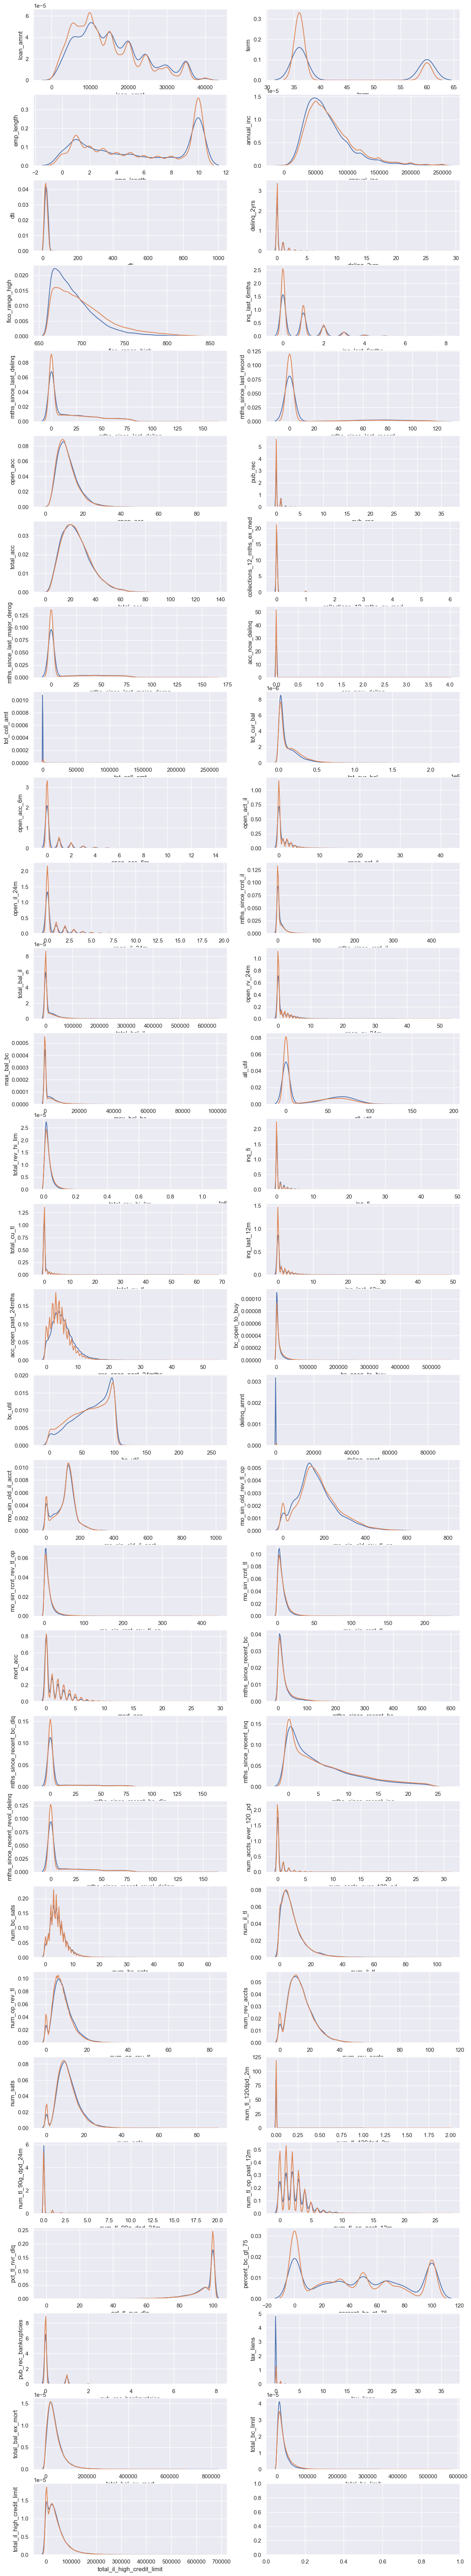

In [20]:
nb = 1
for var in [x for x in df_loan.columns.values if x not in not_predictor]:
    if df_loan[var].dtype == np.float64 or df_loan[var].dtype == np.int64:
        nb = nb + 1
fig, ax = plt.subplots(nb//2, 2, figsize=(15,90))
i = 0
for var in [x for x in df_loan.columns.values if x not in not_predictor]:
    if df_loan[var].dtype == np.float64 or df_loan[var].dtype == np.int64:
        sns.kdeplot(df_loan[df_loan.loan_status=='Charged Off'][var], label='Charged Off', ax=ax[i//2,i % 2])
        sns.kdeplot(df_loan[df_loan.loan_status!='Charged Off'][var], label='Fully Paid', ax=ax[i//2,i % 2])
        ax[i//2,i % 2].set_ylabel(var)
        i = i + 1
        

Looking at the plots above we see that the distribution for census-related features is almost the same accross both classes of loans. We will investigate those features closer using mode-based features selection in the next section.

**One-hot encoding**

We turn the loan status into a binary variable

In [21]:
df_loan.replace({'loan_status':{'Charged Off': 1, 'Fully Paid': 0}}, inplace=True)
df_loan.loan_status = df_loan.loan_status.astype('int')

C:\Users\ianka\AppData\Local\Temp\ipykernel_15148\4018097218.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_loan.replace({'loan_status':{'Charged Off': 1, 'Fully Paid': 0}}, inplace=True)


We convert the `earliest_cr_line` feature to the number of years between the earliest credit line and the year when the loan was requested.

We turn categorical features into binary variables.

In [22]:
df_loan.replace({'term':{36: 1, 60: 0}},inplace=True)

In [23]:
df_loan = pd.get_dummies(df_loan, columns=['emp_length', 'home_ownership','purpose','issue_m',
                                               'grade', 'sub_grade','earliest_cr_line'], drop_first=True)

**Remove irrelevant features**

Let's remove all indentified features above.

In [24]:
df_loan.drop(columns=list(set(not_predictor) & set(df_loan.columns.values)), inplace=True)

### Imbalanced Dataset

As we see below, the data is unbalanced, with Fully Paid loans being the majority class.

In [25]:
nb = df_loan.loan_status.value_counts()
nb

loan_status
0    106554
1     26577
Name: count, dtype: int64

Here, 0 - Fully Paid loans and 1 - Charged Off loans. 

In [26]:
print("We notice, {0:.2%} of the total loans are Charged Off, and about {1:.2%} loans are Fully Paid.".format(nb[0]/np.sum(nb),nb[1]/np.sum(nb)))

We notice, 80.04% of the total loans are Charged Off, and about 19.96% loans are Fully Paid.


**Train/Test/Validation Data Split**

`X` is the feature matrix. `Y` is the response vector.

In [27]:
X, Y = df_loan[df_loan.columns.difference(['loan_status'])], df_loan['loan_status']

We choose to split the whole dataset to 90% training, 10% test, with stratify, resulting in consistent class distribution between training and test sets

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)

Let's further split the training set into a 80% training and a 20% validation set.

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [30]:
print("We verify that the proportion of Charged Off is about the same: {0:.2%} in train, {1:.2%} in val and {2:.2%} in test".format(len(y_train[y_train==0])/len(y_train),
                                                                                                                                   len(y_val[y_val==0])/len(y_val),
                                                                                                                                   len(y_test[y_test==0])/len(y_test)))

We verify that the proportion of Charged Off is about the same: 80.04% in train, 80.04% in val and 80.04% in test


We will now have a closer look at the imbalanced classes.

Let's reduce the dimension of a subset of the data using Principal Component Analysis (PCA) and display the imbalanced classes in a 2D plot.

In [31]:
X_train_subset = X_train[:100]
y_train_subset = y_train[:100]
pca = PCA(n_components=2)
X_train_subset = pca.fit_transform(X_train_subset)

In [32]:
y_train_subset.value_counts()

loan_status
0    79
1    21
Name: count, dtype: int64

In [33]:
# source code adapted from [6]
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    labels = ['Charged Off', 'Fully Paid']
    for d, l, c, m in zip(labels, np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=d, marker=m, alpha=.5
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.show()

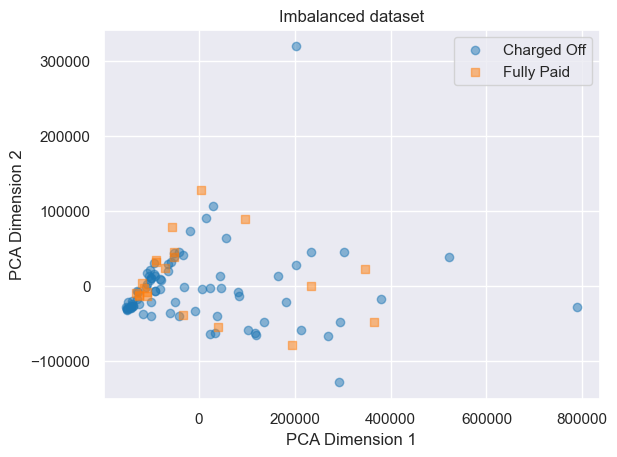

In [34]:
plot_2d_space(X_train_subset, y_train_subset, 'Imbalanced dataset')

The plot above is a visual confirmation of the imbalanced classes in our data.

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of either removing samples from the majority class (under-sampling) or adding more examples from the minority class (over-sampling). Both strategies can also be applied at the same time.

As shown below with under-sampling, we tend to loose valuable information, which can increase bias.

58 random samples removed


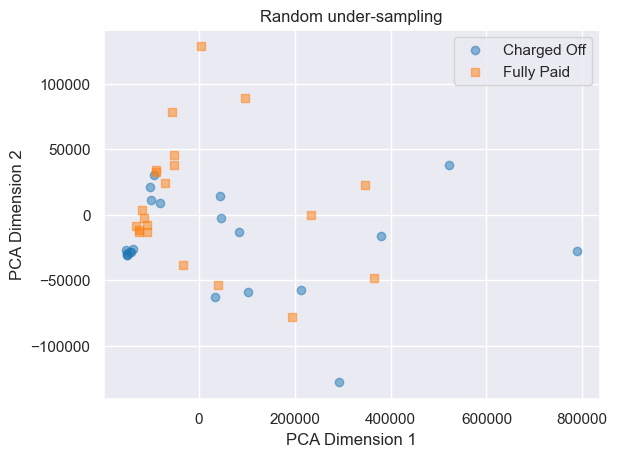

In [35]:
rus = RandomUnderSampler()
X_train_subset_rus, y_train_subset_rus= rus.fit_resample(X_train_subset, y_train_subset)

print(X_train_subset.shape[0] - X_train_subset_rus.shape[0], 'random samples removed')
plot_2d_space(X_train_subset_rus, y_train_subset_rus, 'Random under-sampling')

In over-sampling the most naive strategy is to generate new samples by randomly sampling with replacement the current available samples, which can cause overfitting.

58 random samples added


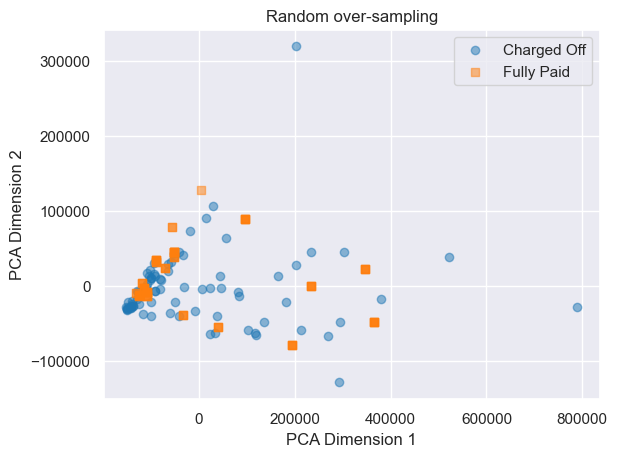

In [36]:
ros = RandomOverSampler()
X_train_subset_ros, y_train_subset_ros = ros.fit_resample(X_train_subset, y_train_subset)
print(X_train_subset_ros.shape[0] - X_train_subset.shape[0], 'random samples added')
plot_2d_space(X_train_subset_ros, y_train_subset_ros, 'Random over-sampling')

A number of more sophisticated resapling techniques have been proposed in the scientific literature, especially using the Python library imbalanced-learn [7]. SMOTE (Synthetic Minority Oversampling TEchnique) consists of creating new samples for the minority class, by picking a sample from that class and computing the k-nearest neighbors, then adding a new sample between the chosen sample and its neighbors.

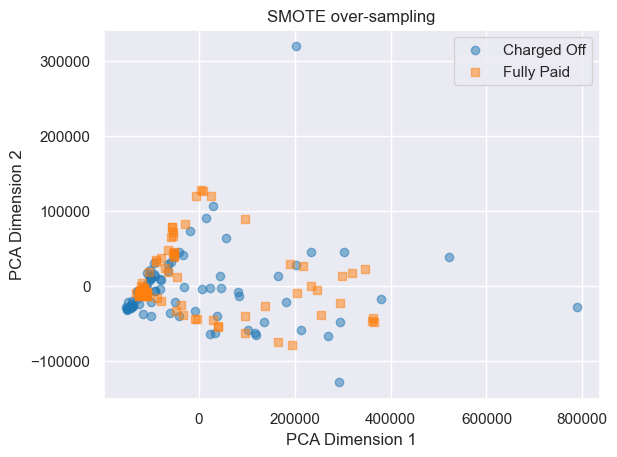

In [37]:
smote = SMOTE(sampling_strategy='minority')
X_train_subset_sm, y_train_subset_sm = smote.fit_resample(X_train_subset, y_train_subset)

plot_2d_space(X_train_subset_sm, y_train_subset_sm, 'SMOTE over-sampling')

**We will use SMOTE to balance our training dataset.** 

In [38]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [39]:
print('The Charged-Off to Fully Paid ratio in the balanced training set is now: ', len(y_train[y_train==0])/len(y_train[y_train==1]))

The Charged-Off to Fully Paid ratio in the balanced training set is now:  1.0


### Model-based features selection

**Insights on features importance**

Looking at the results above, we can bring in following conclusions:

- The term is the most important element each investor has to care about. 68-months loans are highly risky.
- The purpose of loan for credit cards payment brings more confidence to an investor.
- Borrowers who have 10 or more years verified working experience are the most trustworthy investment.
- Home ownership plays a significant role.
- The state of California is a significant factor to be considered when looking at the likelihood of Charged-Off
- Lenders should look at financial KPIs such as inq_last_6mths, num_tl_op_past_12m and acc_open_past_24mths; not just at FICO score, which are less relevant than these KPIs.
- Debt-to-income ratio and annual income can be missleading, and shoudn't be always considered as the most important factors.
- The time of the year when the loan is requested is not so relevant.


We will use classifiers on the training dataset in order to get a better understanding on how features are related to loan outcome as fully paid or unpaid. This will help us reducing the dimensionality of our data by selecting the most important features.

In [6]:
# 1. Load data and remove leaked features
df = pd.read_csv('https://s3.amazonaws.com/ruxton.ai/df_loan_accepted_census_cleaned.csv')
leaky_features = ['success', 'next_pymnt_d', 'last_pymnt_d', 'last_pymnt_amnt', 'id']
X = df.drop(['loan_status'] + leaky_features, axis=1)
y = df['loan_status']

# 2. Encode categoricals (your safe_encode function is good)
X = safe_encode(X.copy())

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Train with cross-validation
randomf = RandomForestClassifier(
    n_estimators=100,  # Increased for stability
    max_depth=10,
    max_samples=0.5,
    max_features='sqrt',  # Better than 0.5 for high-dimensional data
    n_jobs=-1,
    random_state=42,
    verbose=1
)
randomf.fit(X_train, y_train)

# 5. Evaluate
print(f"Test accuracy: {randomf.score(X_test, y_test):.4f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


Test accuracy: 0.9183


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


The random forest is clearly overfit, and is obviously picking the majority class in the validation set.

Below we have a ranking of features as computed by our random forest, depending on their Gini importance in the prediction of loan outcome.

In [9]:
feature_importances = pd.DataFrame(randomf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False).reset_index().rename(columns={'index':'feature'})
feature_importances.head(10)

,feature,importance
0,total_rec_prncp,0.139223
1,issue_q,0.104307
2,collection_recovery_fee,0.103683
3,last_fico_range_low,0.061172
4,total_pymnt_inv,0.056118
5,total_pymnt,0.055144
6,last_fico_range_high,0.055108
7,all_util,0.050006
8,mths_since_rcnt_il,0.040146
9,open_act_il,0.038381


**Important Features**

We will now use SKLearn meta-transformet SelectFromModel to discard irrelevant features using the features importance produced by our random forest.

In [17]:
from sklearn.feature_selection import SelectFromModel

# 1. Feature selection with explicit threshold
fs_model = SelectFromModel(
    randomf, 
    prefit=True,
    threshold='median'  # More explicit than default
)

# 2. Get and validate selected features
selected_mask = fs_model.get_support()
features_list_new = X.columns[selected_mask]

# 3. Cross-check with importance scores
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': randomf.feature_importances_
}).sort_values('importance', ascending=False)

print(f'Selected {len(features_list_new)}/{len(X.columns)} features:')
print(features_list_new.tolist())
print('\nTop 20 features by importance:')
print(importance_df.head(20))

Selected 52/104 features:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'annual_inc', 'verification_status', 'issue_d', 'title', 'dti', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'collection_recovery_fee', 'last_fico_range_high', 'last_fico_range_low', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'num_actv_rev_tl', 'num_il_tl', 'num_rev_accts', 'num_tl_op_past_12m', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'issue_q', 'issue_m']

Top 20 features by importance:
                    feature  importance
33          total_rec_prncp  

In [19]:
# Use the dataframe you already loaded earlier (df_loan_accepted_census_cleaned)
# If you don't have it loaded, use:
df_loan_accepted_census_cleaned = pd.read_csv('https://s3.amazonaws.com/ruxton.ai/df_loan_accepted_census_cleaned.csv')

# Now map the selected features back to original columns
loan_variables_selected = []
for col in df_loan_accepted_census_cleaned.columns:
    if any(str(s).startswith(str(col)) for s in features_list_new):
        loan_variables_selected.append(col)

print(f'\nThese selected features correspond to {len(loan_variables_selected)} original columns:')
print(loan_variables_selected)


These selected features correspond to 53 original columns:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'annual_inc', 'verification_status', 'issue_d', 'title', 'dti', 'open_acc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'collection_recovery_fee', 'last_fico_range_high', 'last_fico_range_low', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'num_actv_rev_tl', 'num_il_tl', 'num_rev_accts', 'num_tl_op_past_12m', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'issue_q', 'issue_m']


**Design Matrix with important features**

We can now create the new design matrix using the identified important features.

In [20]:
print("Number of predictors after one-hot encoding is: ",X_train.shape[1])

Number of predictors after one-hot encoding is:  104


In [32]:
# Best practice implementation
fs_model = SelectFromModel(randomf, prefit=True)  # No fitting needed

# Transform while preserving DataFrame structure if possible
X_train_selected = fs_model.transform(X_train)
X_test_selected = fs_model.transform(X_test) 

# Get feature names (if available)
if hasattr(X_train, 'columns'):
    selected_features = X_train.columns[fs_model.get_support()]
    print("Selected features:", list(selected_features))

c:\Users\ianka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\ianka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected features: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'collection_recovery_fee', 'last_fico_range_high', 'last_fico_range_low', 'open_act_il', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_24m', 'max_bal_bc', 'all_util', 'issue_q']


In [31]:
print("Number of predictors after feature selection is ", X_train.shape[1])

Number of predictors after feature selection is  104


**Principal Components Analysis**

We are interested in reducing the dimension of our data further by analysing its principal components. This will allow us to compress the important features into a reduced number of components.

We first start with scaling the data.

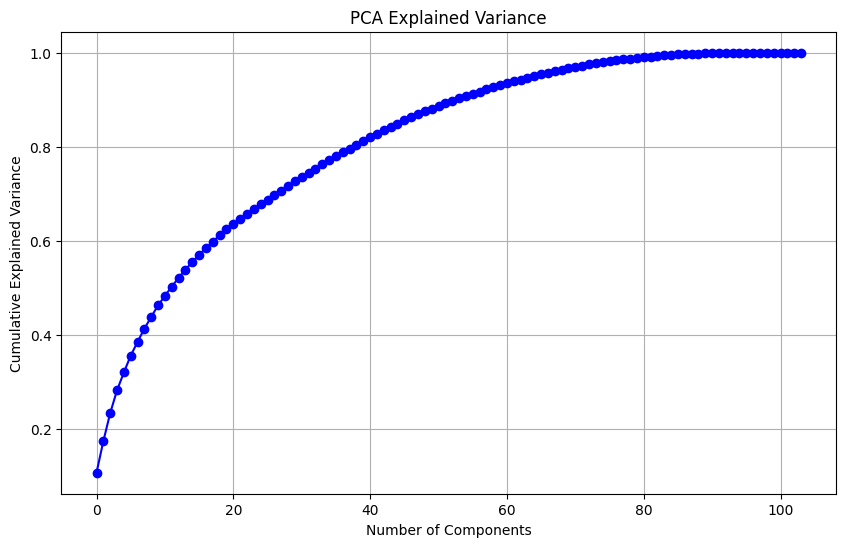

Number of components explaining 95% variance: 65

Original shape: (133885, 104)
Reduced shape: (133885, 65)


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Use same scaler for validation
X_test_scaled = scaler.transform(X_test)  # And test sets

# 2. PCA Analysis
pca = PCA().fit(X_train_scaled)

# Visualize explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'b-o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# 3. Choose optimal components (e.g., 95% variance)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

# 4. Transform all sets
pca_final = PCA(n_components=n_components)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_val_pca = pca_final.transform(X_val_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

print(f"\nOriginal shape: {X_train.shape}")
print(f"Reduced shape: {X_train_pca.shape}")

We decompose the scaled data with PCA

In [34]:
n = X_train.shape[1]
pca_fit = PCA(n).fit(X_train_scaled)

In the plot below, we see that the dimension can be reduced to the number of components which explain at least 90% of variance in the data.

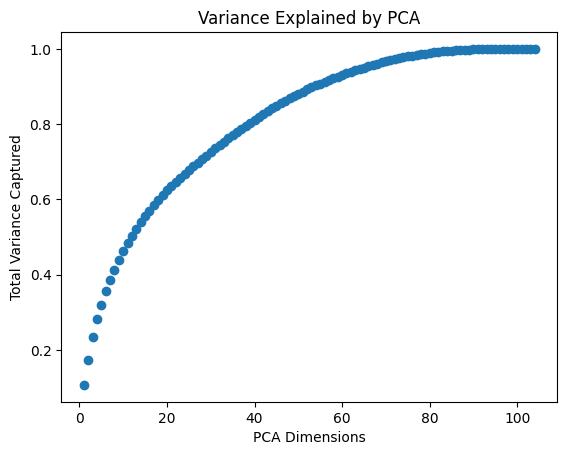

In [35]:
pca_var = np.cumsum(pca_fit.explained_variance_ratio_)
plt.scatter(range(1,n+1),pca_var)
plt.xlabel("PCA Dimensions")
plt.ylabel("Total Variance Captured")
plt.title("Variance Explained by PCA");

We can now rebuild our design matrix using the PCA components.

In [36]:
pca_fit = PCA(25).fit(X_train_scaled)
X_train_pca = pca_fit.transform(X_train)
X_val_pca = pca_fit.transform(X_val)
X_test_pca = pca_fit.transform(X_test)
X_train_scaled_pca = pca_fit.transform(X_train_scaled)
X_val_scaled_pca = pca_fit.transform(X_val_scaled)
X_test_scaled_pca = pca_fit.transform(X_test_scaled)

c:\Users\ianka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\ianka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\ianka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


**Helper function for Design Matrix**

We summarize the above code in the function below, which create all design matrices need for our models.

In [39]:
def get_design_matrices(df, variables = ['loan_amnt', 'term', 'sub_grade', 'grade', 'emp_length', 'home_ownership',
           'annual_inc', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
           'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
           'mths_since_last_record', 'open_acc', 'pub_rec',
            'total_acc', 'collections_12_mths_ex_med',
           'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
           'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
           'bc_open_to_buy', 'bc_util', 'delinq_amnt', 'mo_sin_old_il_acct',
           'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
           'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
           'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
           'num_accts_ever_120_pd', 'num_bc_sats',
           'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_sats',
           'num_tl_120dpd_2m',  'num_tl_90g_dpd_24m',
           'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
           'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort',
           'total_bc_limit', 'total_il_high_credit_limit','earliest_cr_line']):
    
    # raw data
    df_loan = df.copy()
    df_loan = df_loan[df_loan.loan_status.isin(['Charged Off', 'Fully Paid'])]
    df_loan = df_loan[variables]
    # hot encoding
    df_loan.replace({'loan_status':{'Charged Off': 1, 'Fully Paid': 0}}, inplace=True)
    df_loan.loan_status = df_loan.loan_status.astype('int')
    df_loan.replace({'term':{36: 1, 60: 0}},inplace=True)
    df_loan = pd.get_dummies(df_loan, columns=['emp_length', 'home_ownership','purpose',
                                               'grade', 'sub_grade','earliest_cr_line'], drop_first=True)
    # design matrix
    X, Y = df_loan[df_loan.columns.difference(['loan_status'])], df_loan['loan_status']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)
    X_test_df = X_test
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
    # upsampling
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    X_val, y_val = smote.fit_resample(X_val, y_val)
    # features selection
    randomf = RandomForestClassifier(n_estimators=100, max_depth=None, oob_score=True).fit(X_train, y_train)
    fs_model = SelectFromModel(randomf, prefit=True)
    X_train = fs_model.transform(X_train)
    X_val = fs_model.transform(X_val)
    X_test = fs_model.transform(X_test)
    # scaling
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    # pca transform
    pca_fit = PCA(.9).fit(X_train_scaled)
    X_train_pca = pca_fit.transform(X_train)
    X_val_pca = pca_fit.transform(X_val)
    X_test_pca = pca_fit.transform(X_test)
    X_train_scaled_pca = pca_fit.transform(X_train_scaled)
    X_val_scaled_pca = pca_fit.transform(X_val_scaled)
    X_test_scaled_pca = pca_fit.transform(X_test_scaled)
    return X_test_df, X_train, y_train, X_val, y_val, X_test, y_test, X_train_scaled, X_val_scaled, X_test_scaled, X_train_scaled_pca, X_val_scaled_pca, X_test_scaled_pca

In [55]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

def get_design_matrices(df, variables):
    """Returns processed data in tuple format for easy unpacking"""
    # Verify all variables exist
    missing = [v for v in variables if v not in df.columns]
    if missing:
        raise KeyError(f"Columns missing: {missing}")
    
    X = df[variables]
    y = df['loan_status']
    
    # Encode string labels to integers
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_
    
    # Check class distribution
    class_counts = np.bincount(y_encoded)
    print("Class distribution:")
    for name, count in zip(class_names, class_counts):
        print(f"{name}: {count} samples")
    
    if np.min(class_counts) < 2:
        print("Warning: Class imbalance detected")
        stratify = None
    else:
        stratify = y_encoded
    
    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, stratify=stratify, random_state=42
    )
    
    # Check validation split stratification
    val_stratify = y_train if np.min(np.bincount(y_train)) >= 2 else None
    
    # Train/Val split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=val_stratify, random_state=42
    )
    
    # SMOTE (train only if sufficient samples)
    if len(np.unique(y_train)) >= 2 and np.min(np.bincount(y_train)) >= 5:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        print("Applied SMOTE oversampling")
    else:
        print("Insufficient samples for SMOTE - using original distribution")
    
    # Scaling
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # PCA (95% variance)
    pca = PCA(n_components=0.95, random_state=42).fit(X_train_scaled)
    X_train_scaled_pca = pca.transform(X_train_scaled)
    X_val_scaled_pca = pca.transform(X_val_scaled)
    X_test_scaled_pca = pca.transform(X_test_scaled)
    
    # Convert y back to original labels if needed
    y_train = le.inverse_transform(y_train)
    y_val = le.inverse_transform(y_val)
    y_test = le.inverse_transform(y_test)
    
    return (
        X_test, X_train, y_train, 
        X_val, y_val, y_test,
        X_train_scaled, X_val_scaled, X_test_scaled,
        X_train_scaled_pca, X_val_scaled_pca, X_test_scaled_pca,
        le  # Return the label encoder for inverse transforms
    )

# Usage example
variables = ['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc']
try:
    results = get_design_matrices(df_loan_accepted_census_cleaned, variables)
    (X_test, X_train, y_train, 
     X_val, y_val, y_test,
     X_train_scaled, X_val_scaled, X_test_scaled,
     X_train_scaled_pca, X_val_scaled_pca, X_test_scaled_pca,
     label_encoder) = results
except Exception as e:
    print(f"Error: {str(e)}")
    print("Check your input data and variables list")

Class distribution:
Charged Off: 26577 samples
Current: 86562 samples
Default: 1 samples
Fully Paid: 106554 samples
In Grace Period: 835 samples
Late (16-30 days): 436 samples
Late (31-120 days): 2178 samples
Insufficient samples for SMOTE - using original distribution


## Classification Models

In the previous section we used a model-based approach for identifying the important features which most probably determine the failure or success of a loan.

Using the features selected, we will now investigate the performance of several models on the validation set via cross-validation. Each model will be trained on the training set. We will also check if dimension reduction via PCA improves the accuracy. 

At the end we will investigate if ensemble technique via stacking of base learners improves classification results.


### Scoring

In classification problems, we can distinguish between the following metrics, whereby **the positive class is Charge Off** and **the negative class is Fully Paid**:

- **Recall or Sensitivity or TPR (True Positive Rate)**: Number of loans correctly identified as positive (fully paid) out of total true positives - TP/(TP+FN)
    
- **Specificity or TNR (True Negative Rate)**: Number of loans correctly identified as negative (charged-off) out of total negatives - TN/(TN+FP)

- **Precision**: Number of loans correctly identified as positive (fully paid) out of total items identified as positive - TP/(TP+FP)
    
- **False Positive Rate or Type I Error**: Number of loans wrongly identified as positive (fully paid) out of total true negatives - FP/(FP+TN)
    
- **False Negative Rate or Type II Error**: Number of loans wrongly identified as negative (charged-off) out of total true positives - FN/(FN+TP)

- A **Confusion Matrix**: visual representation of the number of TP, TN, FP and FN.

- **Accuracy**: Percentage of total items classified correctly - (TP+TN)/(N+P)

- **F1 Score**: Harmonic mean of precision and recall given by - F1 = 2xPrecisionxRecall /(Precision + Recall)

- **ROC-AUC Score**: Area under curve of sensitivity (TPR) vs. specificity (TNR).

- **Log-loss**: Probabilistic confidence of accuracy. High value of log-loss means that the absolute probabilities have big difference from actual labels.  

**Scoring in investment strategy**

Insights from [8] were used in this section.

If we choose an investment strategy that uses absolute probabilistic difference, then we will  look at log-loss with care. If the final class prediction is the most important outcome and we don’t want to tune probability threshold, we will rather use AUC score. But if the threshold is well tuned, then F1 will be the scoring to use.

In loan classification, where positive labels (charged-offs) are few, we would like our model to predict positive classes correctly and hence we will sometime prefer those models which are able to classify these positive labels. Log-loss usually fails to identify model which produces too many false negatives because the log-loss function is symmetric and does not differentiate between classes.  Both F1 score and ROC-AUC score can perform well for class imbalance. F1 is better suit for situations where the negative class is small. Since an investor would care more about the minority class (charged-off loans) in number independent of the fact whether it is positive or negative, then **we think that ROC-AUC score would make sense as benchmark measure.**

**Helper functions for scoring metrics**

The source code from [9] was adjusted in the functions below.

In [56]:
# dataframe where we track all cross-validation scoring metrics
df_cv_scores = pd.DataFrame({'model':['dummy'], 'accuracy':[0], 'f1':[0], 'roc_auc':[0]}, 
                            columns=['accuracy','f1','roc_auc'], index=['model'])
df_cv_scores_pca = df_cv_scores.copy()

df_y_pred_probas = pd.DataFrame() 
df_y_preds = pd.DataFrame() 

In [57]:
# function adjusts class predictions based on the prediction threshold
def adjust_proba(probs, threshold):
    return [1 if proba >= threshold else 0 for proba in probs]

In [58]:
# function for computing 5-fold cross-validation scoring scores
def predict_evaluate_cv(model, X, y, df_cv_scores):
    cv = StratifiedKFold(n_splits=3, random_state=9999,shuffle=True) 
    score_accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    score_f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
    score_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    df_cv_scores.loc[model.__class__.__name__] = [score_accuracy, score_f1, score_auc]
    print('K-fold cross-validation results on validation set:')
    print(" average accuracy is {0:0.2%}".format(score_accuracy))
    print(" average F1 is {0:0.2%}".format(score_f1))
    print(" average roc_auc is {0:0.2%}".format(score_auc))

In [61]:
# function for computing the confusion matrix
def predict_evaluate_cm(model, X, y, threshold=.5):
    model_name = model.__class__.__name__
    classes = ['Fully Paid', 'Charged-Off']
    y_true = y
    if model_name == 'SVC':
        y_pred_proba = model.decision_function(X)
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
    df_y_pred_probas[model_name] = y_pred_proba
    y_pred = adjust_proba(y_pred_proba, threshold)
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float')
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="gray" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.rcParams["axes.edgecolor"] = "0.85"
    plt.show()

In [62]:
# function for compution the roc plot
def predict_evaluate_roc(model, X, y, threshold=.5):
    y_pred = model.predict(X)
    model_name = model.__class__.__name__
    df_y_preds[model_name] = y_pred
    if model_name == 'SVC':
        y_pred_proba = model.decision_function(X)
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
    [fpr, tpr, thr] = roc_curve(y, y_pred_proba)

    idx = np.min(np.where(tpr > threshold))
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve - {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

    print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
          "and a specificity of %.3f" % (1-fpr[idx]) + 
          ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [63]:
# global function for fitting, cross-validating and evaluating a given classifier
def fit_predict_evaluate(model, Xtrain, ytrain, Xval, yval, df_cv_scores):
    model.fit(Xtrain, ytrain)
    print(model.__class__.__name__+":")
    print('Accuracy score on training set is {0:0.2%}'.format(model.score(Xtrain, ytrain)))
    predict_evaluate_cv(model, Xval, yval, df_cv_scores)
    predict_evaluate_cm(model, Xval, yval)
    predict_evaluate_roc(model, Xval, yval)
    return model

## Decision Tree

In [65]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train decision tree
dt_model = DecisionTreeClassifier(max_depth=None, random_state=42)

# If you want to train it (assuming you have the processed data from earlier)
dt_model.fit(X_train, y_train)  # Using X_train and y_train from get_design_matrices()

# Evaluate
from sklearn.metrics import classification_report
y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

       Charged Off       0.19      0.21      0.20      5237
           Current       0.64      0.66      0.65     17431
        Fully Paid       0.65      0.62      0.64     21242
   In Grace Period       0.01      0.01      0.01       182
 Late (16-30 days)       0.00      0.00      0.00        99
Late (31-120 days)       0.01      0.01      0.01       438

          accuracy                           0.58     44629
         macro avg       0.25      0.25      0.25     44629
      weighted avg       0.58      0.58      0.58     44629



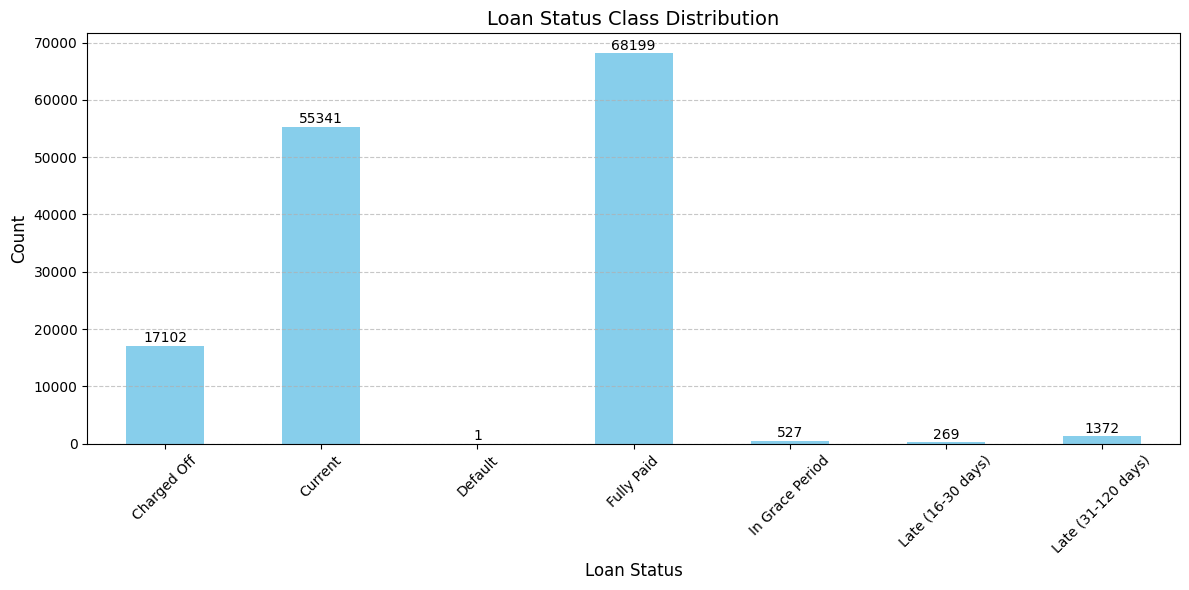

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Your manual weights
manual_weights = {
    'Charged Off': 2,
    'Current': 1,
    'Default': 10,
    'Fully Paid': 1,
    'In Grace Period': 8,
    'Late (16-30 days)': 15,
    'Late (31-120 days)': 5
}

# Initialize model
dt_model = DecisionTreeClassifier(
    class_weight=manual_weights,
    max_depth=5,
    random_state=42
)

# Convert y_train to pandas Series if it's a numpy array
y_train_series = pd.Series(y_train)

# Plot class distribution
plt.figure(figsize=(12,6))
y_train_series.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Loan Status Class Distribution', fontsize=14)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add counts on top of bars
for i, count in enumerate(y_train_series.value_counts().sort_index()):
    plt.text(i, count + 50, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Random Forest

We will now rebuilt our random forest classifier, this time using the important features.

In [69]:
randomf_optim = RandomForestClassifier(n_estimators=200, max_depth=20)

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


Training completed in 2.38 seconds

Classification Report:
                    precision    recall  f1-score   support

       Charged Off       0.20      0.41      0.27      4238
           Current       0.62      0.32      0.42     13790
        Fully Paid       0.62      0.51      0.56     17113
   In Grace Period       0.01      0.11      0.02       126
 Late (16-30 days)       0.00      0.04      0.00        68
Late (31-120 days)       0.02      0.17      0.04       368

          accuracy                           0.42     35703
         macro avg       0.25      0.26      0.22     35703
      weighted avg       0.56      0.42      0.47     35703



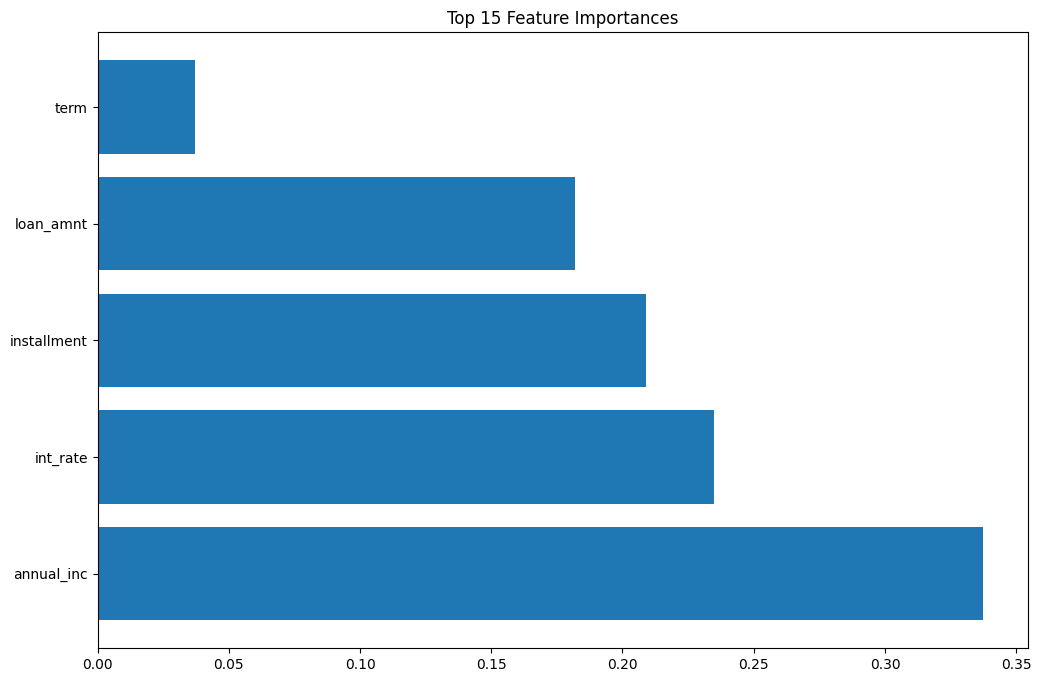

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# 1. Initialize with optimized parameters
randomf_optim = RandomForestClassifier(
    n_estimators=50,          # Reduced from default 100
    max_depth=10,             # Shallower trees
    min_samples_leaf=20,      # Larger leaf nodes
    max_features='sqrt',      # Fewer features per split
    class_weight='balanced',  # Handle imbalance
    n_jobs=-1,               # Use all cores
    random_state=42,
    verbose=1                # Show progress
)

# 2. Train with timer
import time
start = time.time()
print("Training Random Forest...")
randomf_optim.fit(X_train, y_train)
print(f"Training completed in {time.time()-start:.2f} seconds")

# 3. Evaluate
y_pred = randomf_optim.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))

# 4. Feature Importance
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': randomf_optim.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12,8))
plt.barh(importances['Feature'][:15], importances['Importance'][:15])
plt.title('Top 15 Feature Importances')
plt.show()

The random forest classifier gives the best accuracy so far.

### Please write code for XG Boosting ###


In [119]:
# Use the native XGBoost API (not scikit-learn wrapper)
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dval = xgb.DMatrix(X_val, label=y_val_encoded)

params = {
    'max_depth': 5,
    'eta': 0.05,
    'objective': 'multi:softmax',
    'num_class': len(label_encoder.classes_)
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    early_stopping_rounds=10,
    evals=[(dval, 'validation')],
    verbose_eval=10
)

[0]	validation-mlogloss:1.88865
[10]	validation-mlogloss:1.51360
[20]	validation-mlogloss:1.31547
[30]	validation-mlogloss:1.19500
[40]	validation-mlogloss:1.11470
[50]	validation-mlogloss:1.05943
[60]	validation-mlogloss:1.01958
[70]	validation-mlogloss:0.99023
[80]	validation-mlogloss:0.96818
[90]	validation-mlogloss:0.95183
[100]	validation-mlogloss:0.93940
[110]	validation-mlogloss:0.92985
[120]	validation-mlogloss:0.92209
[130]	validation-mlogloss:0.91539
[140]	validation-mlogloss:0.90960
[150]	validation-mlogloss:0.90427
[160]	validation-mlogloss:0.89980
[170]	validation-mlogloss:0.89563
[180]	validation-mlogloss:0.89137
[190]	validation-mlogloss:0.88794
[199]	validation-mlogloss:0.88484


## Please write code for any other model of your choice ##

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'alpha': 0.01, 'fit_prior': True}
MultinomialNB AUC-ROC: 0.5345


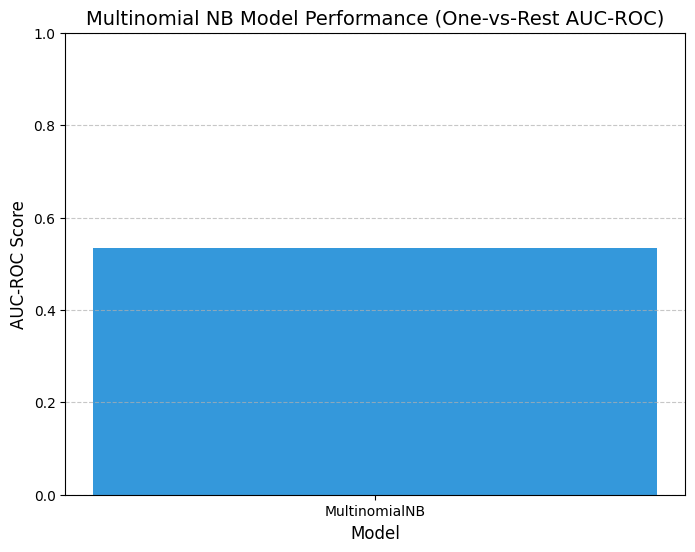

In [156]:
# import numpy as np
# import pandas as pd
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import GridSearchCV

# # First, handle class imbalance using SMOTE (excluding the empty "Default" class)
# non_default_mask_train = y_train != "Default"
# X_train_filtered = X_train[non_default_mask_train]
# y_train_filtered = y_train[non_default_mask_train]

# # Apply SMOTE to balance classes
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

# # Function to fit, predict and evaluate model with hyperparameter tuning
# def fit_predict_evaluate(model, X_train, y_train, X_val, y_val, scores_df=None):
#     # Define parameter grid for Multinomial NB
#     param_grid = {
#         'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
#         'fit_prior': [True, False]
#     }
    
#     # Grid search with cross-validation
#     grid_search = GridSearchCV(
#         model, param_grid, cv=5, 
#         scoring='balanced_accuracy', n_jobs=-1, verbose=1
#     )
    
#     # Fit the model with the resampled data
#     grid_search.fit(X_train, y_train)
    
#     # Get best model
#     best_model = grid_search.best_estimator_
#     print(f"Best parameters: {grid_search.best_params_}")
    
#     # Predict on validation set
#     y_pred = best_model.predict(X_val)
    
#     # Evaluate
#     print("Confusion Matrix:")
#     cm = confusion_matrix(y_val, y_pred)
#     print(cm)
    
#     print("\nClassification Report:")
#     cr = classification_report(y_val, y_pred, zero_division=0)
#     print(cr)
    
#     # Add scores to dataframe if provided
#     if scores_df is not None:
#         # Extract metrics from classification report
#         report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
        
#         # Use pd.concat instead of append (which is deprecated)
#         new_row = pd.DataFrame({
#             'Model': ['MultinomialNB'],
#             'Accuracy': [report['accuracy']],
#             'Weighted Precision': [report['weighted avg']['precision']],
#             'Weighted Recall': [report['weighted avg']['recall']],
#             'Weighted F1': [report['weighted avg']['f1-score']]
#         })
#         scores_df = pd.concat([scores_df, new_row], ignore_index=True)
    
#     return best_model, scores_df

# # Create and train the Multinomial NB model
# MultinomialNB_model = MultinomialNB()
# df_cv_scores = pd.DataFrame() if 'df_cv_scores' not in locals() else df_cv_scores
# MultinomialNB_optim, df_cv_scores = fit_predict_evaluate(
#     MultinomialNB_model, 
#     X_train_resampled, y_train_resampled, 
#     X_val, y_val, 
#     df_cv_scores
# )

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Define a new MultinomialNB model
MultinomialNB_model = MultinomialNB()

# Define parameters for grid search
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

# Perform grid search
grid_search = GridSearchCV(
    MultinomialNB_model, param_grid, cv=5,
    scoring='balanced_accuracy', n_jobs=-1, verbose=1
)

# Fit model - make sure X_train_resampled and y_train_resampled are defined
grid_search.fit(X_train_resampled, y_train_resampled)

# Get best model
MultinomialNB_optim = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Function for multiclass AUC-ROC calculation
def predict_roc_multiclass(model, X, y):
    """Calculate ROC AUC for multi-class classification using One-vs-Rest approach"""
    # Get unique classes
    classes = np.unique(y)
    
    # One-vs-Rest approach
    y_bin = label_binarize(y, classes=classes)
    
    # Get probabilities for each class
    y_score = model.predict_proba(X)
    
    # Calculate ROC AUC for each class and get the average
    if len(classes) > 2:
        auc_roc = roc_auc_score(y_bin, y_score, multi_class='ovr', average='macro')
    else:
        auc_roc = roc_auc_score(y_bin, y_score[:, 1])
        
    return auc_roc

# Calculate AUC-ROC for the MultinomialNB model
auc_roc_value = predict_roc_multiclass(MultinomialNB_optim, X_test, y_test)
print(f"MultinomialNB AUC-ROC: {np.round(auc_roc_value, 4)}")

# Visualization for the single model
plt.figure(figsize=(8, 6))
plt.bar(0, auc_roc_value, color='#3498db', width=0.5)
plt.xlabel('Model', fontsize=12)
plt.ylabel('AUC-ROC Score', fontsize=12)
plt.xticks([0], ['MultinomialNB'], fontsize=10)
plt.title('Multinomial NB Model Performance (One-vs-Rest AUC-ROC)', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Compare the performance of all models ##

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Function for training models with grid search
def train_model_with_grid_search(model, param_grid, X_train, y_train, model_name):
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        model, param_grid, cv=5,
        scoring='balanced_accuracy', n_jobs=-1, verbose=1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    return best_model

# Function for calculating AUC-ROC for multi-class
def predict_roc_multiclass(model, X, y):
    classes = np.unique(y)
    y_bin = label_binarize(y, classes=classes)
    y_score = model.predict_proba(X)
    
    if len(classes) > 2:
        auc_roc = roc_auc_score(y_bin, y_score, multi_class='ovr', average='macro')
    else:
        auc_roc = roc_auc_score(y_bin, y_score[:, 1])
        
    return auc_roc

# 1. Decision Tree
dt_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt_model = train_model_with_grid_search(
    DecisionTreeClassifier(random_state=42),
    dt_params, 
    X_train_resampled, 
    y_train_resampled,
    "Decision Tree"
)

# 2. Random Forest
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}
randomf_optim = train_model_with_grid_search(
    RandomForestClassifier(random_state=42),
    rf_params, 
    X_train_resampled, 
    y_train_resampled,
    "Random Forest"
)

# 3. XGBoost
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_optim = train_model_with_grid_search(
    XGBClassifier(random_state=42),
    xgb_params, 
    X_train_resampled, 
    y_train_resampled,
    "XGBoost"
)

# Now evaluate all models including MultinomialNB_optim
models = [dt_model, randomf_optim, xgb_optim, MultinomialNB_optim]
model_names = ['Decision Tree', 'Random Forest', 'XGBoost', 'MultinomialNB']
auc_roc_values = []

for i, model in enumerate(models):
    auc_roc_t = predict_roc_multiclass(model, X_test, y_test)
    auc_roc_values.append(auc_roc_t)
    print(f"{model_names[i]}: {np.round(auc_roc_t, 4)}")

# Visualization
plt.figure(figsize=(10, 6))
index = np.arange(len(auc_roc_values))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

plt.bar(index, auc_roc_values, color=colors, width=0.6)
plt.xlabel('Models', fontsize=12)
plt.ylabel('AUC-ROC Score', fontsize=12)
plt.xticks(index, model_names, fontsize=10)
plt.title('Model Comparison (One-vs-Rest AUC-ROC)', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above each bar
for i, v in enumerate(auc_roc_values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Model': model_names,
    'AUC-ROC Score': auc_roc_values
})
results_df = results_df.sort_values('AUC-ROC Score', ascending=False)
print("\nModels Ranked by Performance:")
print(results_df)

Training Decision Tree...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
Training Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
